No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


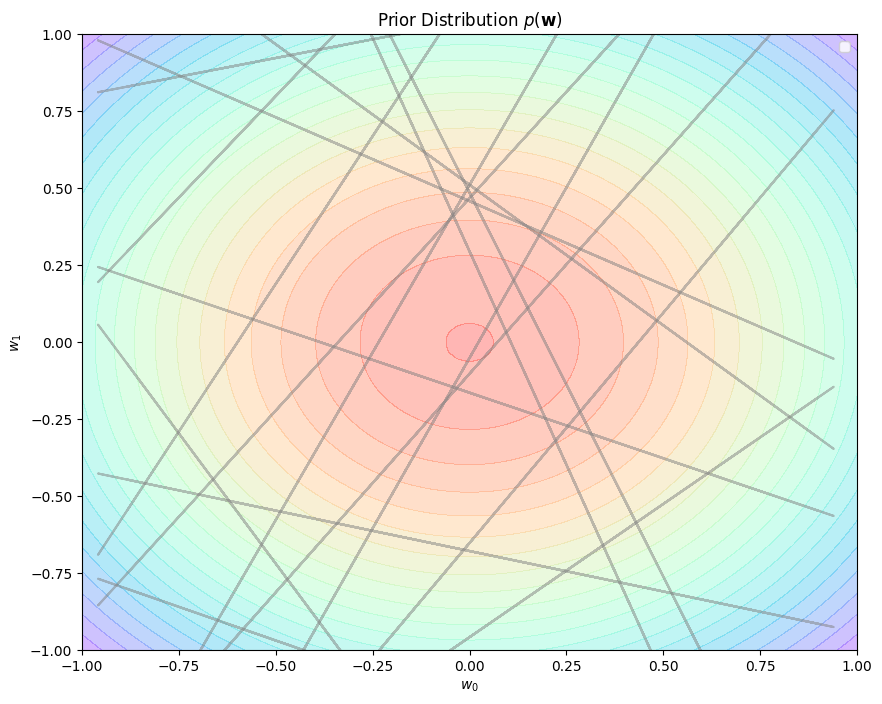

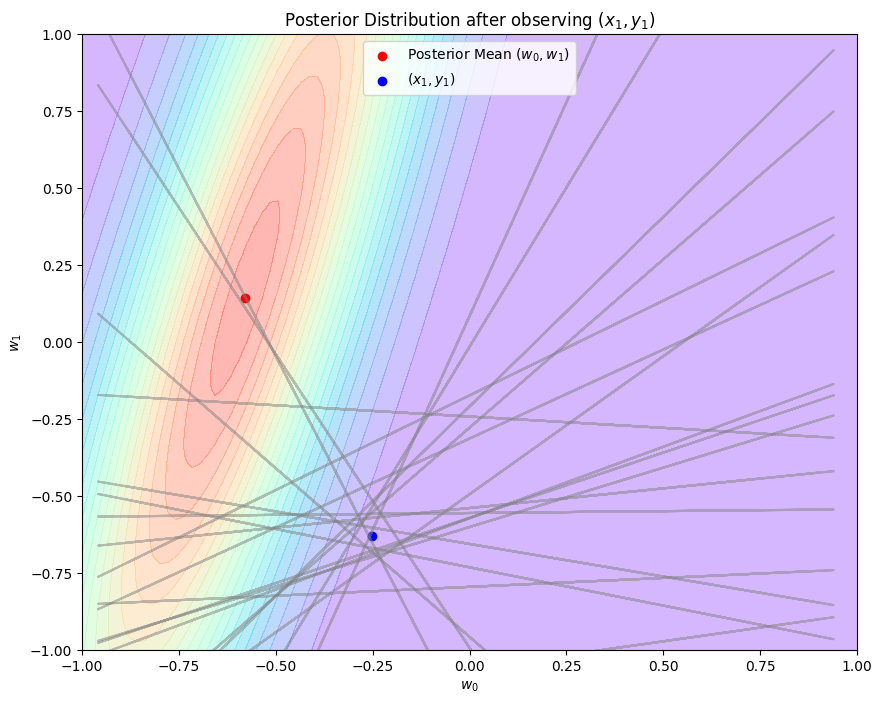

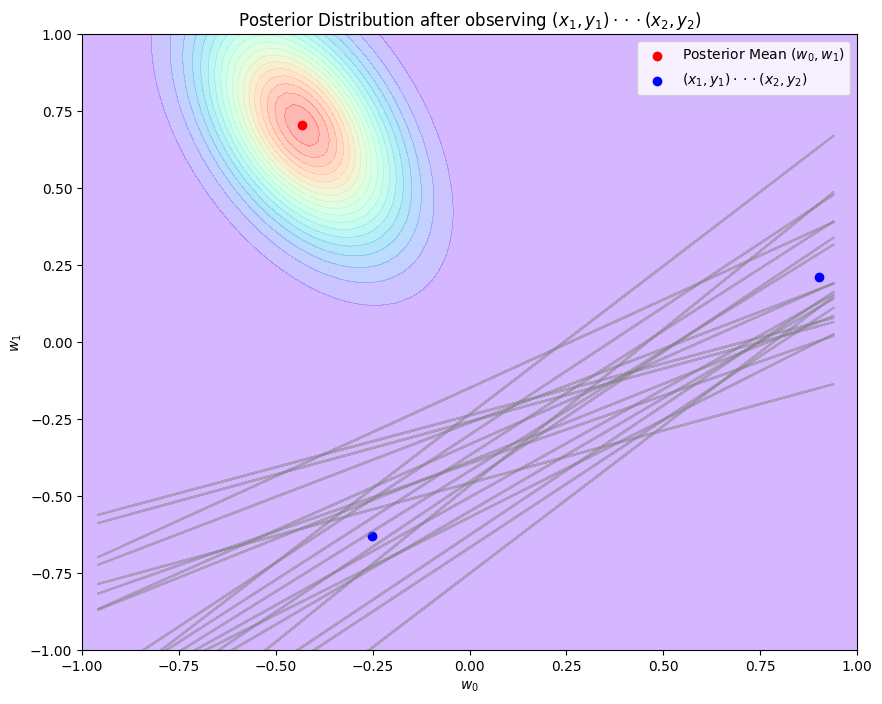

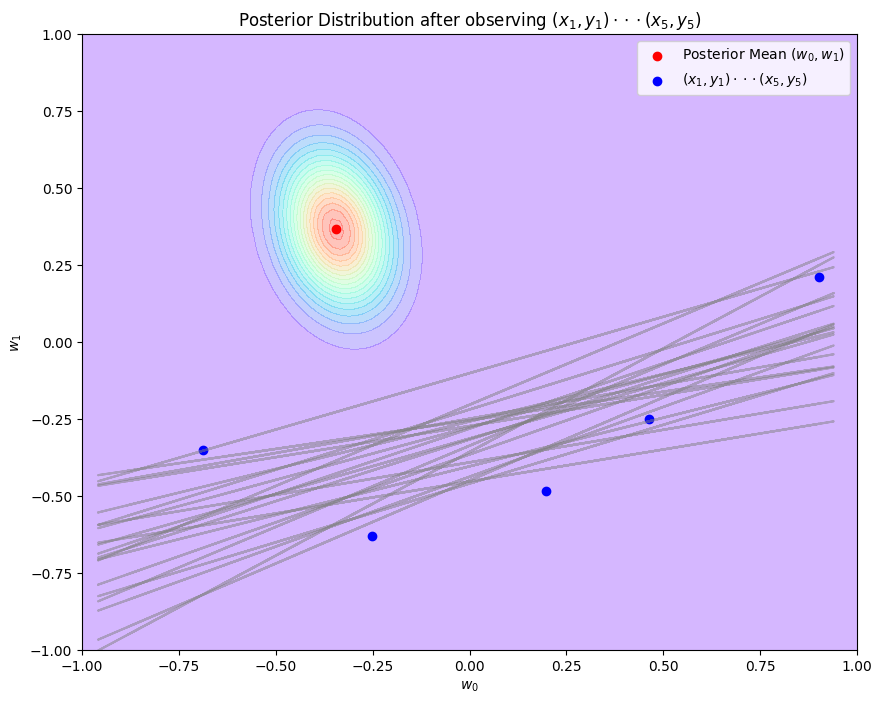

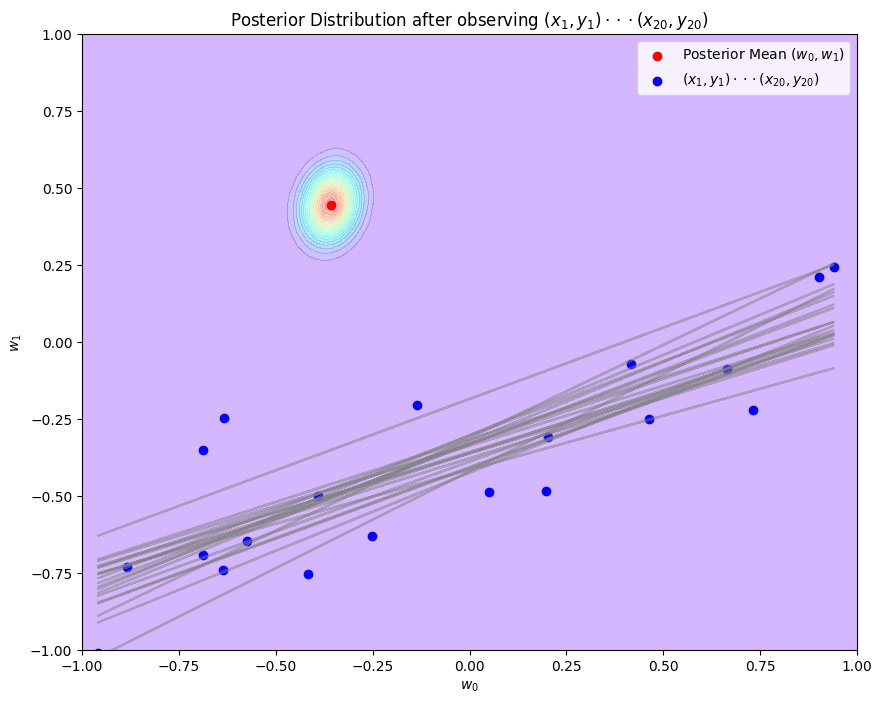

In [116]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

# Set random seed for reproducibility
np.random.seed(42)

# Task 1
# Define parameters
w0_true, w1_true = -0.3, 0.5
alpha, beta = 2, 25
num_samples = 20

# Generate data
X = np.random.uniform(-1, 1, num_samples)
noise = np.random.normal(0, 0.2, num_samples)
Y_true = w0_true + w1_true * X
Y = Y_true + noise

# Prior distribution parameters
prior_mean = np.zeros(2)
prior_covariance = alpha * np.eye(2)

# Plot the heat-map of the prior
w0_range = np.linspace(-1, 1, 100)
w1_range = np.linspace(-1, 1, 100)
W0, W1 = np.meshgrid(w0_range, w1_range)
prior_pdf = multivariate_normal.pdf(np.dstack((W0, W1)), mean=prior_mean, cov=prior_covariance)
plt.figure(figsize=(10, 8))
plt.contourf(W0, W1, prior_pdf, cmap='rainbow', levels=20, alpha=0.3)
plt.title('Prior Distribution $p(\\mathbf{w})$')
plt.xlabel('$w_0$')
plt.ylabel('$w_1$')

# Sample 20 instances from the prior
prior_samples = np.random.multivariate_normal(prior_mean, prior_covariance, size=20)

# Plot the lines corresponding to the sampled weights
#plt.scatter(prior_samples[:, 0], prior_samples[:, 1], c='black', marker='x', label='Sampled $\\mathbf{w}$')

for w in prior_samples:
    # xs = []
    # ys = []
    # for x, y in zip(X, w[0] + w[1] * X):
    #     if np.abs(x) <= 1 and np.abs(y) <=1:
    #         xs.append(x)
    #         ys.append(y)
    # #print(X > -1, w[0] + w[1] * X)
    # plt.plot(xs, ys, c='gray', alpha=0.5)
    plt.plot(X, w[0] + w[1] * X, c='gray', alpha=0.5)

plt.legend()
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.show()

# Task 2
# Calculate posterior after observing the first data point (X[0], Y[0])
# posterior_covariance = np.linalg.inv(np.linalg.inv(prior_covariance) + beta * np.outer([1, X[0]], [1, X[0]]))
# print(posterior_covariance)


def calculate_plot_posterior(prior_mean, prior_covariance, n_points=1, sample_size=20):
    posterior_covariance = np.linalg.inv(np.linalg.inv(prior_covariance) + beta * np.matmul(np.array([[1, X[i]] for i in range(n_points)]).T, np.array([[1, X[i]] for i in range(n_points)])))
    # posterior_mean = np.dot(posterior_covariance, np.dot(np.linalg.inv(prior_covariance), prior_mean) + beta * np.array([1, X[0]]) * Y[0])
    # print('original', posterior_mean)

    posterior_mean = beta * np.matmul(posterior_covariance, np.matmul(np.array([[1, X[i]] for i in range(n_points)]).T, np.array([Y[:n_points]]).T)).T[0]

    #posterior_mean = np.dot(posterior_covariance, np.dot(np.linalg.inv(prior_covariance), prior_mean) + beta * np.matmul(np.array([[1, X[i]] for i in range(n_points)]) * np.array([Y[:n_points]]).T))
    #print('mine', posterior_mean)
    #print(np.array([[1, X[i]] for i in range(n_points)]).T.shape, np.array([Y[:n_points]]).shape)
    # Plot posterior distribution
    posterior_pdf = multivariate_normal.pdf(np.dstack((W0, W1)), mean=posterior_mean, cov=posterior_covariance)
    plt.figure(figsize=(10, 8))
    plt.contourf(W0, W1, posterior_pdf, cmap='rainbow', levels=20, alpha=0.3)
    plt.scatter(posterior_mean[0], posterior_mean[1], c='red', marker='o', label='Posterior Mean $(w_0, w_1)$')
    plt.title('Posterior Distribution after observing ' + ('$(x_1, y_1)$' if n_points == 1 else '$(x_1, y_1) \\cdot \\cdot \\cdot (x_{%s}, y_{%s})$'%(n_points, n_points)))
    plt.xlabel('$w_0$')
    plt.ylabel('$w_1$')

    # Sample 20 instances from the posterior
    posterior_samples = np.random.multivariate_normal(posterior_mean, posterior_covariance, size=sample_size)

    # Plot the lines corresponding to the sampled weights
    for w in posterior_samples:
        plt.plot(X, w[0] + w[1] * X, c='gray', alpha=0.5)

    plt.scatter(X[:n_points], Y[:n_points], c='blue', marker='o', label='$(x_1, y_1)$' if n_points == 1 else '$(x_1, y_1) \\cdot \\cdot \\cdot (x_{%s}, y_{%s})$'%(n_points, n_points))
    plt.legend()
    plt.xlim(-1,1)
    plt.ylim(-1,1)
    plt.savefig(f'../imgs/hw2/posterior_contour_{n_points}.png')
    plt.show()

for n_points in [1, 2, 5, 20]:
    calculate_plot_posterior(prior_mean, prior_covariance, n_points)


In [178]:
import numpy as np
import pandas as pd
from scipy.stats import norm
from scipy.optimize import minimize

np.random.seed(42)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def logistic_regression(X, y, max_iter=100, tol=1e-5, random_init=False, learning_rate=1):
    n_samples, n_features = X.shape
    weights = np.zeros(n_features) if not random_init else np.random.randn(n_features)
    if learning_rate != 1:
        print('learning rate:', learning_rate)
    for _ in range(max_iter):
        #print(weights)
        logits = np.dot(X, weights)
        #print(logits)
        predicted_probs = sigmoid(logits)
        gradient = np.dot(X.T, predicted_probs - y) - weights
        R = np.diag(predicted_probs * (1 - predicted_probs))
        hessian = np.dot(np.dot(X.T, R), X)
        try:
            weights_update = np.dot(np.linalg.inv(hessian + np.eye(len(hessian))), gradient)
        except:
            print(weights_update, 'updates')
            break
        #print(weights_update)
        weights_old = weights
        weights = weights - learning_rate*weights_update
        #weights += weights_update
        
        if np.linalg.norm(weights-weights_old) < tol:
            break
    print('iteratations:', _, 'norm:', np.linalg.norm(weights-weights_old))
    return weights

def predict_logistic(X, weights):
    logits = np.dot(X, weights)
    return (logits >= 0).astype(int)

def probit_log_likelihood(X, y, weights):
    logits = np.dot(X, weights)
    probit_vals = norm.cdf(logits)
    log_likelihood = np.sum(y * np.log(probit_vals+1) + (1 - y) * np.log(2 - probit_vals))
    return log_likelihood

def probit_regression(X, y, max_iter=100, tol=1e-5, random_init=False):
    n_samples, n_features = X.shape
    weights = np.zeros(n_features) if not random_init else np.random.randn(n_features)
    

    def objective(w):
        log_prior = -0.5 * np.sum(w ** 2)  # Log-prior term for standard normal prior
        return -(probit_log_likelihood(X, y, w) + log_prior)
    
    result = minimize(objective, weights, method='L-BFGS-B', tol=tol, options={'maxiter': max_iter, 'disp': False})
    #print(result)
    weights = result.x
    
    return weights

def probit_regression_nr(X, y, max_iter=100, tol=1e-5, random_init=False, learning_rate=1):
    n_samples, n_features = X.shape
    weights = np.zeros(n_features) if not random_init else np.random.randn(n_features)
    if learning_rate != 1:
        print('learning rate:', learning_rate)
    for _ in range(max_iter):
        #print(weights)
        logits = np.dot(X, weights)
        #print(logits)
        predicted_probs = norm.cdf(logits)
        gradient = np.dot(X.T, predicted_probs - y) - weights
        R = np.diag(predicted_probs * (1 - predicted_probs))
        hessian = np.dot(np.dot(X.T, R), X)
        try:
            weights_update = np.dot(np.linalg.inv(hessian + np.eye(len(hessian))), gradient)
        except:
            print(weights_update, 'updates')
            break
        #print(weights_update)
        weights_old = weights
        weights = weights - learning_rate*weights_update
        #weights += weights_update
        
        if np.linalg.norm(weights-weights_old) < tol:
            break
    print('iteratations:', _, 'norm:', np.linalg.norm(weights-weights_old))
    return weights

def predict_probit(X, weights):
    logits = np.dot(X, weights)
    return (logits >= 0).astype(int)

# Load data
train_data = pd.read_csv('../data/bank-note/train.csv', header=None)
test_data = pd.read_csv('../data/bank-note/test.csv', header=None)
#print(train_data)
X_train, y_train = train_data.iloc[:, :-1].values, train_data.iloc[:, -1].values
X_test, y_test = test_data.iloc[:, :-1].values, test_data.iloc[:, -1].values
#print(X_train, y_train)

# Logistic Regression
weights_logistic = logistic_regression(X_train, y_train, learning_rate=0.1)
print(weights_logistic)
predictions_logistic = predict_logistic(X_test, weights_logistic)
accuracy_logistic = np.mean(predictions_logistic == y_test)
print(f"Logistic Regression Accuracy: {accuracy_logistic:.4f}")
print()

# Logistic Regression with Random Initialization
weights_logistic_rand = logistic_regression(X_train, y_train, random_init=True, learning_rate=0.1)
print(weights_logistic_rand)
predictions_logistic_rand = predict_logistic(X_test, weights_logistic_rand)
accuracy_logistic_rand = np.mean(predictions_logistic_rand == y_test)
print(f"Logistic Regression with Random Initialization Accuracy: {accuracy_logistic_rand:.4f}")
print()

# Probit Regression
weights_probit = probit_regression(X_train, y_train)
print(weights_probit)
predictions_probit = predict_probit(X_test, weights_probit)
accuracy_probit = np.mean(predictions_probit == y_test)
print(f"Probit Regression Accuracy: {accuracy_probit:.4f}")
print()

# Probit Regression with Random Initialization
weights_probit_rand = probit_regression(X_train, y_train, random_init=True)
print(weights_probit_rand)
predictions_probit_rand = predict_probit(X_test, weights_probit_rand)
accuracy_probit_rand = np.mean(predictions_probit_rand == y_test)
print(f"Probit Regression with Random Initialization Accuracy: {accuracy_probit_rand:.4f}")
print()

# Probit Regression
weights_probit_nr = probit_regression_nr(X_train, y_train, learning_rate=0.1)
print(weights_probit_nr)
predictions_probit_nr = predict_probit(X_test, weights_probit_nr)
accuracy_probit_nr = np.mean(predictions_probit_nr == y_test)
print(f"Probit Regression using Newton-Raphson Accuracy: {accuracy_probit_nr:.4f}")
print()

# Probit Regression with Random Initialization
weights_probit_rand_nr = probit_regression_nr(X_train, y_train, random_init=True, learning_rate=0.1)
print(weights_probit_rand_nr)
predictions_probit_rand_nr = predict_probit(X_test, weights_probit_rand_nr)
accuracy_probit_rand_nr = np.mean(predictions_probit_rand_nr == y_test)
print(f"Probit Regression using Newton-Raphson with Random Initialization Accuracy: {accuracy_probit_rand_nr:.4f}")
print()


learning rate: 0.1
iteratations: 99 norm: 0.02211572785417097
[-3.78885653 -2.43701038 -2.64014444 -1.17200142]
Logistic Regression Accuracy: 0.9500

learning rate: 0.1
iteratations: 99 norm: 0.021542561085902957
[-3.80468179 -2.44887259 -2.65285104 -1.17842157]
Logistic Regression with Random Initialization Accuracy: 0.9500

[-2.16075399 -1.10753816 -1.22210417 -0.4115619 ]
Probit Regression Accuracy: 0.9520

[-2.16367674 -1.1049877  -1.22041736 -0.4113803 ]
Probit Regression with Random Initialization Accuracy: 0.9520

learning rate: 0.1
iteratations: 93 norm: 8.84918181591823e-06
[-1.75498508 -1.07345094 -1.17062846 -0.50266115]
Probit Regression using Newton-Raphson Accuracy: 0.9520

learning rate: 0.1
iteratations: 97 norm: 9.148761224019748e-06
[-1.75498377 -1.07345002 -1.17062743 -0.50266078]
Probit Regression using Newton-Raphson with Random Initialization Accuracy: 0.9520



In [24]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from collections import Counter

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def softmax(X):
    exp_X = np.exp(X - np.max(X, axis=1, keepdims=True))
    return exp_X / np.sum(exp_X, axis=1, keepdims=True)

def log_likelihood(X, y, weights):
    logits = np.dot(X, weights)
    probs = softmax(logits)
    return np.sum(y * np.log(probs))

def one_hot_encode(y, n_classes):
    encoded = np.zeros((len(y), n_classes))
    for i, label in enumerate(y):
        encoded[i, label] = 1
    return encoded

def multi_class_logistic_regression(X, y, n_classes, max_iter=100, tol=1e-5):
    n_samples, n_features = X.shape
    weights = np.zeros((n_features, n_classes))
    
    def objective(w):
        logits = np.dot(X, w)
        return -log_likelihood(X, y, w)
    
    result = minimize(objective, weights, method='L-BFGS-B', options={'maxiter': max_iter, 'disp': False})
    weights = result.x.reshape((n_features, n_classes))
    
    return weights

def predict_multi_class(X, weights):
    logits = np.dot(X, weights)
    probs = softmax(logits)
    return np.argmax(probs, axis=1)

def binary_logistic_regression(X, y, max_iter=100, tol=1e-5):
    n_samples, n_features = X.shape
    weights = np.zeros(n_features)
    
    def objective(w):
        logits = np.dot(X, w)
        return -log_likelihood(X, y, w)
    
    result = minimize(objective, weights, method='L-BFGS-B', options={'maxiter': max_iter, 'disp': False})
    weights = result.x
    
    return weights

def predict_binary(X, weights):
    logits = np.dot(X, weights)
    return (logits >= 0).astype(int)

# Load data
train_data = pd.read_csv('../data/car-1/train.csv', header=None)
test_data = pd.read_csv('../data/car-1/test.csv', header=None)

X_train, y_train_lab = train_data.iloc[:, :-1].values, train_data.iloc[:, -1].values
X_test, y_test_lab = test_data.iloc[:, :-1].values, test_data.iloc[:, -1].values

classes = set(y_train_lab)
classes = dict(zip(np.sort(list(classes)), list(range(len(classes)))))
print(classes)
y_train = [classes[y] for y in y_train_lab]
y_test = [classes[y] for y in y_test_lab]

# Convert categorical features into binary features
unique_values = [np.unique(X_train[:, i]) for i in range(X_train.shape[1])]
n_classes = len(np.unique(y_train))
X_train_encoded = np.concatenate([np.eye(len(vals))[np.searchsorted(vals, X_train[:, i])] for i, vals in enumerate(unique_values)], axis=1)
X_test_encoded = np.concatenate([np.eye(len(vals))[np.searchsorted(vals, X_test[:, i])] for i, vals in enumerate(unique_values)], axis=1)

# Multi-class Logistic Regression
y_train_encoded = one_hot_encode(y_train, n_classes)
weights_multi_class = multi_class_logistic_regression(X_train_encoded, y_train_encoded, n_classes)
predictions_multi_class = predict_multi_class(X_test_encoded, weights_multi_class)
accuracy_multi_class = np.mean(predictions_multi_class == y_test)
print(f"Multi-class Logistic Regression Accuracy: {accuracy_multi_class:.4f}")

# Binary Logistic Regression (Ugly Trick)
labels = np.unique(y_train)
binary_predictions = np.zeros((len(X_test), len(labels)))

for i, label in enumerate(labels):
    y_train_binary = (y_train == label).astype(int)
    weights_binary = binary_logistic_regression(X_train_encoded, y_train_binary)
    binary_predictions[:, i] = predict_binary(X_test_encoded, weights_binary)

final_predictions = np.argmax(binary_predictions, axis=1)
accuracy_binary = np.mean(final_predictions == y_test)
print(f"Binary Logistic Regression (Ugly Trick) Accuracy: {accuracy_binary:.4f}")


{'acc': 0, 'good': 1, 'unacc': 2, 'vgood': 3}


ValueError: 'x0' must only have one dimension.